# Some examples of using Paicos

This script shows how to

- load data
- make projections and slices
- save them as an 'ArepoImage'
- how to convert the Arepo data from comoving code units to physical values in various unit systems


## Compilation
The first step is to compile the code, this only needs to be done the first time you use Paicos (uncomment all four lines and replace the path to your own cloned version)

In [ ]:
#%%bash
#cd /llust21/berlok/paicos
#make clean
#make

## Loading arepo snapshots

We load a zoom factor 12 galaxy cluster simulation below

In [3]:
import paicos as pa
import numpy as np
# simfolder = '/llust21/cosmo-plasm/zoom-simulations/halo_0003/gal-form/zoom12/'
simfolder = '/home/lena/analysis/paicos/data/'

# A snapshot object
# snap = pa.Snapshot(simfolder + 'output', 130)
snap = pa.Snapshot(simfolder, 247)

# The center of the most massive Friends-of-friends group in the simulation
center = snap.Cat.Group['GroupPos'][0]

# The available fields for a PartType can be found as shown below
keys = snap.info(0)

# by starting to type and using tab-completion, i.e., snap['0_  and then hit tab


Keys for PartType0 in the hdf5 file:
0_AllowRefinement
0_CenterOfMass
0_Coordinates
0_Density
0_ElectronAbundance
0_EnergyDissipation
0_GFM_AGNRadiation
0_GFM_CoolingRate
0_GFM_Metallicity
0_GFM_Metals
0_GFM_WindDMVelDisp
0_GFM_WindHostHaloMass
0_HighResGasMass
0_InternalEnergy
0_Machnumber
0_MagneticField
0_MagneticFieldDivergence
0_MagneticFieldDivergenceAlternative
0_Masses
0_NeutralHydrogenAbundance
0_ParticleIDs
0_Potential
0_StarFormationRate
0_SubfindDMDensity
0_SubfindDensity
0_SubfindHsml
0_SubfindVelDisp
0_Velocities
0_VelocityGradient

Possible derived variables are:
0_Enstrophy
0_EnstrophyTimesMasses
0_GFM_MetallicityTimesMasses
0_MachnumberTimesEnergyDissipation
0_MagneticFieldNorm
0_MagneticFieldNormSquaredTimesVolume
0_MagneticFieldSquared
0_MagneticFieldSquaredTimesVolume
0_MagneticFieldStrength
0_MeanMolecularWeight
0_NumberDensity
0_Pressure
0_PressureTimesVolume
0_TM2
0_Temperatures
0_TemperaturesTimesMasses
0_VelocityCurvature
0_VelocityMagnitude
0_VelocityNorm
0_V

/home/lena/analysis/paicos/paicos/readers/arepo_snap.py:311: UserWarning: Deleting the user function: <function JetTracerTimesVolume at 0x7faa7260cc10> because its dependency: ['0_Jet_Tracer'] is missing
  warnings.warn(msg)


We can look at some of snaps attributes:

In [6]:
print(snap.age)
print(snap.lookback_time)
print(snap.cosmo)
snap.box_size
# print(snap.Config)
# print(snap.Parameters)
# print(snap.Header)
# print(snap.z)

13.802234761023938 Gyr
3.552713678800501e-15 Gyr
LambdaCDM(H0=67.32117 km / (Mpc s), Om0=0.31582309, Ode0=0.68417691, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.04938682)


<PaicosQuantity [1000000., 1000000., 1000000.] arepo_length small_a / small_h>


Loading of data can be done using function calls or by trying to access them explicitly.

In [7]:
# Load some variables from the PartType 0 (gas variables) 

# You can explicitly load using function call:
snap.load_data(0, 'Coordinates')
snap['0_Coordinates']

# But is much easier to just do it like this:
snap['0_Density']
snap['0_MagneticField']

# snap
snap

{'0_Coordinates': <PaicosQuantity [[398974.38664031, 211664.99241881, 629966.18799266],
                  [398976.06220306, 211673.62420764, 629972.16363372],
                  [398964.31625223, 211694.87219766, 629968.63209753],
                  ...,
                  [393981.6486238 , 216358.23435912, 632567.69214245],
                  [413556.57386753, 205239.91933755, 632523.87499566],
                  [387187.82099398, 221055.93044903, 631203.24971741]] arepo_length small_a / small_h>,
 '0_Density': <PaicosQuantity [9.72843845e-04, 9.07135545e-04, 8.41988483e-04, ...,
                  2.11899547e-08, 8.11731959e-10, 2.60725130e-08] arepo_density small_h2 / small_a3>,
 '0_MagneticField': <PaicosQuantity [[-5.34967659e-03,  9.29034129e-03,  1.30361943e-02],
                  [ 1.09101562e-02,  2.09588166e-02, -1.89505350e-02],
                  [-1.48704611e-02, -2.39538439e-02,  2.79470757e-02],
                  ...,
                  [-1.05035404e-07,  1.10529356e-07,  1.7658

In [8]:
snap['0_GFM_MetallicityTimesMasses']

<PaicosQuantity [5.43420047e-04, 5.12088270e-04, 5.83514372e-04, ...,
                 2.38755311e-12, 6.40401851e-13, 2.35471915e-12] arepo_mass / small_h>

This loads a PaicosQuantity (basically a subclass of an astropy quantity). Here we can see the units used in the simulation. small_h and small_a are the reduced Hubble parameter and the scale factor, respectively. These quantities have the following useful methods:

In [9]:
# Unit conversion
rho = snap['0_Density']
print('rho[0] in CGS:\t', rho[0].cgs)
print('rho[0] in SI:\t', rho[0].si)
print("rho[0] in 'astro' units:\t", rho[0].astro)
print("rho[0] in Msun/au^3:\t", rho[0].to('Msun/au3'), '\n\n')

# Get rid of h factors
print('rho[0] without h:\t', rho[0].no_small_h)

# Get rid of both a and h factors
print('rho[0] without a and h:\t', rho[0].to_physical, '\n\n')

# Get a label for use in plots
print(rho.label(r'\rho'))
print(rho.astro.label(r'\rho'))

rho[0] in CGS:	 6.586066423538464e-25 g small_h2 / (cm3 small_a3)
rho[0] in SI:	 6.586066423538463e-22 kg small_h2 / (m3 small_a3)
rho[0] in 'astro' units:	 9731321.74428584 small_h2 solMass / (kpc3 small_a3)
rho[0] in Msun/au^3:	 1.1089103378991942e-18 small_h2 solMass / (AU3 small_a3) 


rho[0] without h:	 0.00044090644374425626 arepo_density / small_a3
rho[0] without a and h:	 0.00044090644374425653 arepo_density 


$\rho\;a^{-3}h^{2}\; \left[\mathrm{arepo\_density}\right]$
$\rho\;a^{-3}h^{2}\; \left[\mathrm{M_{\odot}}\;\mathrm{kpc}^{-3}\right]$


Please note that all these methods return a new object without modifying the original data. Modification can be done by overwriting, e.g., like this:

In [10]:
rho = rho.to_physical
rho

<PaicosQuantity [4.40906444e-04, 4.11126523e-04, 3.81600963e-04, ...,
                 9.60358397e-09, 3.67888283e-10, 1.18164277e-08] arepo_density>

In [11]:
rho.unit

Unit("arepo_density")

You can also automatically calculate derived variables, e.g.:

In [12]:
snap['0_Volume']
snap['0_TemperaturesTimesMasses']
snap['0_VelocityCurvature']

<PaicosQuantity [4.76833045e-02, 5.19320271e-02, 6.24084163e-02, ...,
                 5.97784143e-04, 2.52423954e-05, 8.01124829e-04] small_h / (arepo_length small_a)>

## Making projections

We now use the Paicos projector class, the 'widths' vector is the size of the considered box in x,y,z coordinates. This box is centered at 'center' vector.

The direction can be set to 'x', 'y' or 'z'. If the direction is 'z' (as below) then widths[2] is the depth of the projection and the 2D returned array is in the xy plane.

npix is the number of pixels in the horizontal direction of the image. The width/height ratio should be such that $$npix*height/width$$ is an integer.

There are two projector classes: Projector and TreeProjector. The first one is an SPH projector and the latter a tree projector.

**Important**: When using the TreeProjector class, you should pay attention to the parameter "additive" (previously "extrinsic") which is set to True by default. If additive=True (e.g. mass), the projector creates multiple slices which are summed. If additive=False (e.g. density), the projector takes the mean of multiples slices. One should think about whether the quantity they want to project is extrinsic or intrinsic.

In [13]:
widths = [26000, 13000, 10000]
projector = pa.Projector(snap, center, widths, 'z', npix=2048)

/home/lena/analysis/paicos/paicos/readers/arepo_snap.py:311: UserWarning: Deleting the user function: <function JetTracerTimesVolume at 0x7faa7260cc10> because its dependency: ['0_Jet_Tracer'] is missing
  warnings.warn(msg)


We can call the project_variable method as below. This method can take a number of standard strings (which then internally calls the get_variable function, see further details below) or it can take an array. Both methods are shown below.

In [14]:
Masses = projector.project_variable('0_Masses')
Volumes = projector.project_variable(snap['0_Volume'])
rho = Masses/Volumes

rho

<PaicosQuantity [[5.97826609e-10, 5.98904216e-10, 5.99944873e-10, ...,
                  2.74327529e-09, 2.72723099e-09, 2.70893193e-09],
                 [5.99086484e-10, 6.00146927e-10, 6.01168837e-10, ...,
                  2.75638145e-09, 2.74090042e-09, 2.72323553e-09],
                 [6.00303730e-10, 6.01347285e-10, 6.02351306e-10, ...,
                  2.76934974e-09, 2.75277902e-09, 2.73567615e-09],
                 ...,
                 [2.68398067e-09, 2.69577298e-09, 2.70587085e-09, ...,
                  1.04739363e-09, 1.04956438e-09, 1.05179782e-09],
                 [2.67791900e-09, 2.69019352e-09, 2.70069908e-09, ...,
                  1.05066476e-09, 1.05288808e-09, 1.05517628e-09],
                 [2.67089558e-09, 2.68372597e-09, 2.69470154e-09, ...,
                  1.05405620e-09, 1.05633479e-09, 1.05868058e-09]] arepo_density small_h2 / small_a3>

In general, one should not project quantities without using a weight: $\overline{x} = \frac{\sum_{i=1}^{n} w_i x_i}{\sum_{i=1}^{n} w_i}$

For example, instead of projecting temperature, one could project temperature with a mass weighting

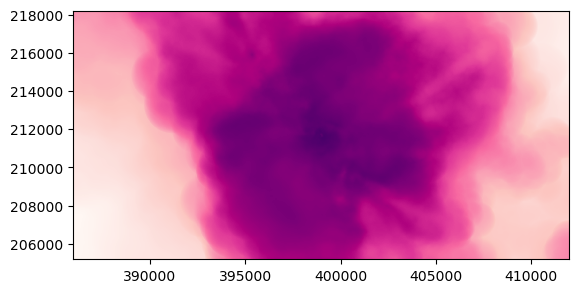

In [23]:
TemperatureTimesMasses = projector.project_variable('0_TemperaturesTimesMasses')
temperature = TemperatureTimesMasses/Masses

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('image', origin='lower', cmap='RdPu', interpolation='None')
plt.imshow(temperature, cmap='RdPu', extent=projector.extent.value, norm=LogNorm())

We can now plot the projected density

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('image', origin='lower', cmap='RdBu_r', interpolation='None')
plt.imshow(rho, cmap='YlGnBu', extent=projector.extent.value, norm=LogNorm())
# plt.savefig('Z24_snap130_wide_projection.pdf', dpi=2000, bbox_inches='tight')

## Making slices

Next, we will take a look at making a slice through the simulation. The width is by definition zero, and the user has to set this explicitly by setting a zero in the 'widths' vector. Below we show a slice of density, comparing with the projected density.

In [ ]:
widths = [26000, 13000, 0]
slicer = pa.Slicer(snap, center, widths, 'z', npix=2048)

In [ ]:
plt.figure(1)
plt.clf()
fix, axes = plt.subplots(nrows=2)

# Slice by passing an array
rho_slice = slicer.slice_variable(snap['0_Density'])

# Slice by passing a string (see snap.info(0) for the available strings)
rho_slice = slicer.slice_variable('0_Density')

# Now plot slice and projection next to each other
axes[0].imshow(rho_slice.to_physical, norm=LogNorm())
axes[1].imshow(rho, norm=LogNorm())
axes[0].set_title('Slice')
axes[1].set_title('Projected')
for ii in range(2):
    axes[ii].set_axis_off()
# plt.savefig('halo3_Z12_slice_projec_comparison.pdf', dpi=2000, bbox_inches='tight')

We can also make slices of other variables. The Slicer object stores the required information (indices of the Voronoi cells closest to the image grid points), so the computing time needed for making additional slices is neglibible.

Let us for instance consider the enstrophy which gives an indication of the amount of turbulence in the galaxy cluster.
It is defined as

1/2|∇×v|²

and can be found from the 'VelocityGradient' field (the 3x3 tensor of velocity derivatives, ∂ᵢvⱼ). This is done internally below:

In [ ]:
extent = slicer.extent.to('Mpc')

plt.imshow(slicer.slice_variable('0_Enstrophy'),
           extent=extent.value,
           norm=LogNorm())

## Storing image data

The computing time for slices, and in particular, projections, is often quite long. It is therefore convenient to be able to store the image data so that this step is de-coupled from the often many matplotlib iterations.

Below I illustrate how to save an Arepo image, created using either a Projector or Slicer object.

In [ ]:
image_file = pa.ArepoImage(slicer, basedir=pa.root_dir + '/data/',
                           basename='test_arepo_image_format')

image_file.save_image('Density', slicer.slice_variable('0_Density'))
image_file.save_image('Enstrophy', slicer.slice_variable('0_Enstrophy'))

image_file.finalize()

The constructed file is found at:

In [ ]:
image_file.filename

Now lets open this image and looks at its contents:

In [ ]:
import h5py
f = h5py.File(image_file.filename, 'r')

In [ ]:
list(f.keys())

Here 'Config', 'Header', 'Parameters' are groups copied over from the snapshot file used to create the image (.0.hdf5 when there are multiple files). 'Density' and 'Enstrophy' is 2D array with the saved images. The group 'image_info' contains essential information about the image, namely:

In [ ]:
print(f['image_info'].keys())
print(f['image_info'].attrs.keys())

We can plot the image and use 'image_info' to get the extent of the image.

In [ ]:
im = plt.imshow(f['Density'], extent=f['image_info']['extent'], norm=LogNorm())
cbar = plt.colorbar(im, fraction=0.025, pad=0.04)

## Getting the units right

The plot above is still in comoving code units, we can use the ImageReader class to automatically get the image data in the form of PaicosQuantities (i.e. with units and in-built methods for manipulation). All the relevant information is stored in the image file, e.g.:

In [ ]:
dict(f['Density'].attrs)

In [ ]:
im = pa.ImageReader(basedir=pa.root_dir + '/data/', snapnum=130,
                 basename='test_arepo_image_format')

extent = im.extent.to('Mpc').no_small_h #.to_physical
rho = im['Density'].to_physical
rho = rho.astro
rho = rho.cgs
image = plt.imshow(rho, extent=extent.value, norm=LogNorm())
cbar = plt.colorbar(image, fraction=0.025, pad=0.04)
cbar.set_label(rho.label('\\rho'))
plt.xlabel(extent.label('x'))
plt.ylabel(extent.label('y'))